# Soot Formation in Flames

Welcome to the **Soot Formation in Flames** notebook — a practical walkthrough to simulate the **partitioning and growth of soot precursors** using the [**Particula**](https://github.com/uncscode/particula) Python package.

This example models the transformation of flame-emitted **aromatic compounds** into **condensed-phase particles** (e.g. PAHs and soot) during **cooling of combustion plumes**.

### 🔥 What This Notebook Covers

In this notebook, you'll learn how to:

1. **Define a realistic suite of aromatic and polyaromatic hydrocarbons (PAHs)** from combustion
2. **Set up temperature-dependent vapor pressure and partitioning**
3. **Simulate a two-stage cooling profile** of a flame parcel
4. **Track gas-to-particle conversion and coagulation** for soot growth
5. **Visualize mass transfer and particle-phase evolution**

### 💡 Why It Matters

Understanding soot formation is critical for:

* Assessing **air pollution and climate impacts** of combustion emissions
* Evaluating **combustion efficiency and emissions**
* Connecting with **health exposure** and regulatory metrics

### 🚀 Getting Started

This example is beginner-friendly. It walks through every step of simulating a **cooling and condensing parcel** from a flame. No prior experience with **Particula** or advanced aerosol thermodynamics is required.


In [1]:
# 🚧 Install Particula if you're running this in Google Colab
# Remove the comment below to enable installation
# !pip install particula[extra] --quiet

# 📦 Import necessary libraries
import copy  # to safely duplicate Python objects
from typing import Union

import matplotlib.pyplot as plt  # for plotting
import numpy as np  # numerical tools
import particula as par  # the main Particula package
from matplotlib.colors import LogNorm
from numpy.typing import NDArray
from tqdm import tqdm  # optional: for progress bars during simulation

# 🎨 Set default plot styling using Tailwind-inspired colors from Particula
TAILWIND = par.util.colors.TAILWIND
base_color = TAILWIND["gray"]["600"]

plt.rcParams.update(
    {
        "text.color": base_color,
        "axes.labelcolor": base_color,
        "figure.figsize": (5, 4),
        "font.size": 14,
        "axes.edgecolor": base_color,
        "xtick.color": base_color,
        "ytick.color": base_color,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

# 🌌 Define the colors for the chemical species involved in the simulation
color_list = (
    # 1–2 ring aromatics (amber)
    [
        TAILWIND["amber"][shade]
        for shade in ["400", "500", "600", "700", "800", "900"]
    ]
    +
    # 3–4 ring PAHs (sky)
    [
        TAILWIND["sky"][shade]
        for shade in [
            "300",
            "400",
            "500",
            "600",
            "700",
            "800",
            "900",
            "200",
        ]
    ]
    +
    # 5–7 ring PAHs (rose)
    [
        TAILWIND["rose"][shade]
        for shade in [
            "300",
            "400",
            "500",
            "600",
            "700",
            "800",
            "900",
            "200",
        ]
    ]
    +
    # Extra-large PAH surrogate (slate)
    [TAILWIND["slate"]["800"]]
    +
    # Fullerene (indigo)
    [TAILWIND["indigo"]["700"]]
)

## 🧪 Defining the Chemical Inventory and Properties

To model soot formation from combustion emissions, we start by specifying a **realistic chemical inventory** of aromatic hydrocarbons. These include both **gas-phase precursors** and **low-volatility polycyclic aromatic hydrocarbons (PAHs)** responsible for early-stage particle growth and soot inception.

We also assign **mass fractions** that approximate real-world emission ratios, for primary combustion aerosols.

**📋 Chemical List**

Our inventory includes:

* **1–2 ring aromatics** (e.g. benzene, toluene) – highly volatile gas-phase precursors
* **2–4 ring PAHs** (e.g. naphthalene, pyrene) – semi-volatile and early particle growth contributors
* **5–7 ring PAHs** (e.g. benzo\[a]pyrene, coronene) – low volatility, soot-nucleating species
* **Optional soot seed** (e.g. fullerene) – inert core for modeling inception

**⚖️ Assigning Mass Fractions**

Mass fractions are allocated to approximate emission contributions, with normalization to ensure the total sums to 1:

> Note: 65% is distributed among volatile aromatics and 35% among PAHs.

**Fetching Thermophysical Properties**

For each chemical, we use `particula.util.get_chemical_search()` to retrieve the database entry, then fetch properties at standard temperature and pressure using `get_chemical_stp_properties()`.

This builds the core property arrays required for simulation, including **molar mass**, **density**, and **surface tension** — key inputs for modeling **evaporation**, **condensation**, and **partitioning**.



In [2]:
# Define species list grouped by volatility
list_of_chemicals = [
    # 1–2-ring aromatics (gas-phase precursors, ~65%)
    "Benzene",
    "Toluene",
    "Ethylbenzene",
    "p-Xylene",
    "Styrene",
    "Indene",
    # 2–4-ring PAHs (semi-volatile, ~35%)
    "Naphthalene",
    "Acenaphthylene",
    "Acenaphthene",
    "Anthracene",
    "Fluoranthene",
    "Pyrene",
    "Chrysene",
    "Benzo[a]anthracene",
    # 5–7-ring PAHs (low volatility)
    "Benzo[b]fluoranthene",
    "Benzo[k]fluoranthene",
    "Benzo[a]pyrene",
    "Perylene",
    "Benzo[ghi]perylene",
    "Indeno[1,2,3-cd]pyrene",
    "Dibenzo[a,h]anthracene",
    "Coronene",
    # Optional ≥7-ring surrogate and soot seed
    "Ovalene",
    "Fullerene",
]

# Initial mass fractions (normalized)
initial_mass_fractions = np.array(
    [
        # ------- 1–2-ring aromatics (~65%)
        0.20,
        0.15,
        0.10,
        0.10,
        0.05,
        0.05,
        # ------- 2–4-ring PAHs (~35%)
        0.12068966,
        0.01931034,
        0.01448276,
        0.01448276,
        0.02896552,
        0.02896552,
        0.01448276,
        0.00965517,
        # ------- 5–7-ring PAHs
        0.01448276,
        0.00965517,
        0.00965517,
        0.00724138,
        0.00724138,
        0.00482759,
        0.00337931,
        0.00241379,
        0.00144828,
        0.00072414,
    ],
    dtype=np.float64,
)

# Normalize to sum to 1
initial_mass_fractions /= np.sum(initial_mass_fractions)

# Initialize property arrays
density_array = np.array([])
molar_mass_array = np.array([])
surface_tension_array = np.array([])
cas_name = []
chemical_dict = {}

# Retrieve and store properties
for chem in list_of_chemicals:
    cas = par.util.get_chemical_search(chem)
    print(f"{chem}: {cas}")
    chemical_dict[chem] = par.util.get_chemical_stp_properties(cas)

    molar_mass_array = np.append(
        molar_mass_array, chemical_dict[chem]["molar_mass"]
    )
    density_array = np.append(density_array, chemical_dict[chem]["density"])
    surface_tension_array = np.append(
        surface_tension_array, chemical_dict[chem]["surface_tension"]
    )
    cas_name.append(cas)

# Display property summary
for chem, props in chemical_dict.items():
    print(f"{chem}:")
    print(f"  Molar Mass: {props['molar_mass']:.4f} kg/mol")
    print(f"  Density: {props['density']:.2f} kg/m³")
    print(f"  Surface Tension: {props['surface_tension']} N/m")
    print(f"  Vapor Pressure: {props['pure_vapor_pressure']} Pa\n")

Benzene: Benzene
Toluene: Toluene
Ethylbenzene: Ethylbenzene
p-Xylene: p-Xylene
Styrene: Styrene
Indene: Indene
Naphthalene: Naphthalene
Acenaphthylene: Acenaphthylene
Acenaphthene: Acenaphthene
Anthracene: Anthracene
Fluoranthene: Fluoranthene
Pyrene: Pyrene
Chrysene: Chrysene
Benzo[a]anthracene: Benzo[a]anthracene
Benzo[b]fluoranthene: Benzo[b]fluoranthene
Benzo[k]fluoranthene: Benzo[k]fluoranthene
Benzo[a]pyrene: Benzo[a]pyrene
Perylene: Perylene
Benzo[ghi]perylene: Benzo[ghi]perylene
Indeno[1,2,3-cd]pyrene: Indeno[1,2,3-cd]pyrene
Dibenzo[a,h]anthracene: Dibenzo[a,h]anthracene
Coronene: Coronene
Ovalene: Ovalene
Fullerene: Fullerene
Benzene:
  Molar Mass: 0.0781 kg/mol
  Density: 873.76 kg/m³
  Surface Tension: 0.028206202466830844 N/m
  Vapor Pressure: 12695.06760788906 Pa

Toluene:
  Molar Mass: 0.0921 kg/mol
  Density: 862.34 kg/m³
  Surface Tension: 0.027906333880214882 N/m
  Vapor Pressure: 3799.2916085833076 Pa

Ethylbenzene:
  Molar Mass: 0.1062 kg/mol
  Density: 862.64 kg/m³


## 🌡️ Thermodynamic Setup and Property Tables

To accurately simulate gas-to-particle transitions during cooling, we need to initialize:

* **Reproducible random sampling**
* **Simulation volume and particle number density**
* **Temperature-dependent vapor pressure and surface tension** for each species

This allows us to model how each chemical transitions between gas and particle phases over a realistic cooling profile (e.g. flame exhaust).

**🔢 Global Simulation Settings**

We define a **parcel volume**, **particle number concentration**, and a representative **initial temperature**. These choices reflect typical combustion plume environments.

* **Total particle number**: 10⁷ particles/cm³
* **Sampled particles**: 25,000
* **Simulation volume**: adjusted to match real concentration
* **Initial gas temperature**: 1200 K     *# we override this later with a cooling profile*
* **Temperature sweep**: 200–1500 K for vapor pressure and surface tension


**📈 Build Property Tables Over Temperature**

Using the `particula.util` and `particula.gas.TableVaporPressureBuilder`, we compute:

* A **vapor pressure table** for each species over 200–1500 K
* A corresponding **surface tension table**
* Vapor pressure strategies for the simulation

Missing or extreme values are safely clipped to avoid numerical issues.

**📊 Plotting Thermophysical Properties**

Finally, we plot how vapor pressure and surface tension change with temperature for all species — a key step in diagnosing volatility trends and ensuring proper simulation input.

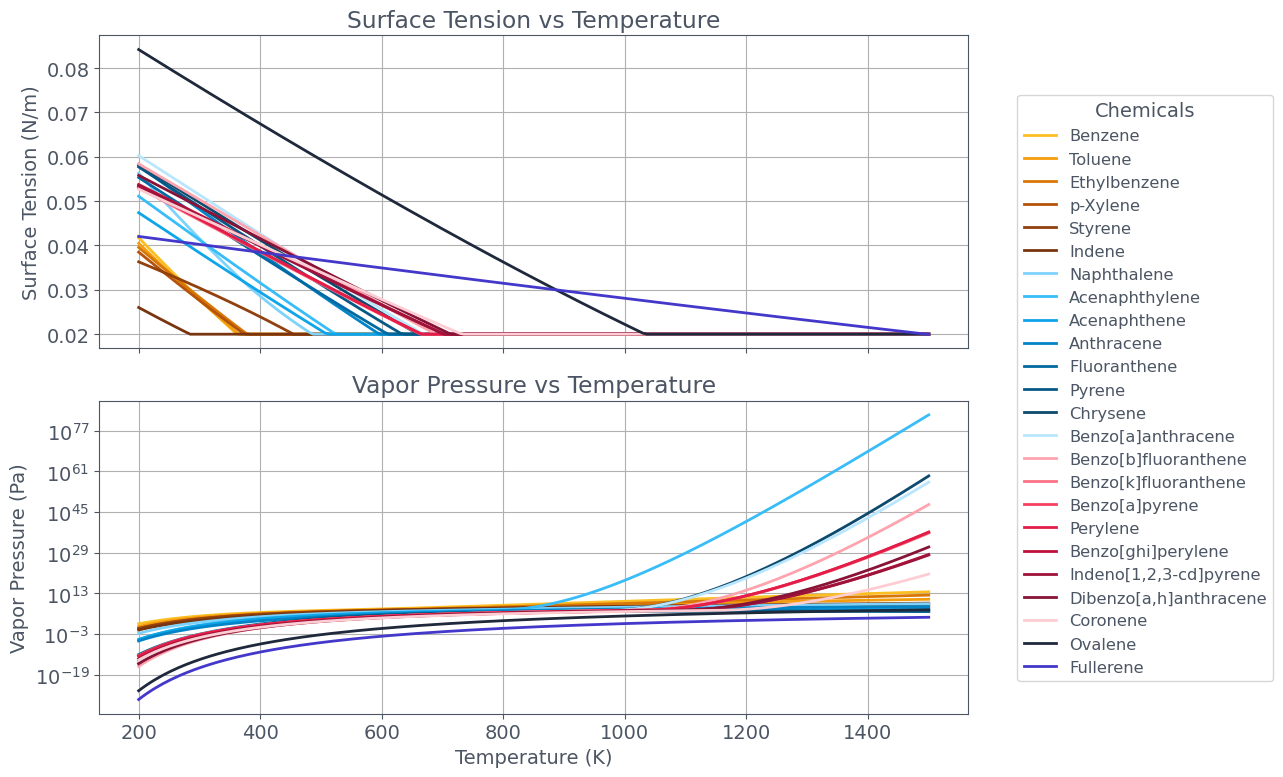

In [3]:
# For reproducibility
np.random.seed(100)

# Simulation parameters
number_of_samples = 25_000  # Simulated particles
total_number_per_cm3 = 10_000_000  # #/cm³
simulation_volume = number_of_samples / total_number_per_cm3 * 1e-6  # m³

# Initial gas phase loading and temperature
total_mass_gas_phase = 5e-5  # kg/m³
temperature = 1200  # Initial gas temperature [K]

# Temperature range for property tables
temperature_range_table = np.linspace(200, 1500, 200)

# Preallocate property tables
vapor_pressure_strategy_list = []
surface_tension_table = np.zeros(
    (len(temperature_range_table), len(list_of_chemicals))
)
vapor_pressure_table = np.zeros(
    (len(temperature_range_table), len(list_of_chemicals))
)

# Loop through chemicals to build property tables
for chem_i in list(chemical_dict.keys()):
    idx = list_of_chemicals.index(chem_i)

    # Vapor pressure vs temperature
    vapor_pressure_temp = par.util.get_chemical_vapor_pressure(
        chemical_identifier=chem_i,
        temperature=temperature_range_table,
    )
    vapor_pressure_table[:, idx] = vapor_pressure_temp

    vapor_pressure_strategy = (
        par.gas.TableVaporPressureBuilder()
        .set_temperature_table(temperature_range_table, "K")
        .set_vapor_pressure_table(vapor_pressure_temp, "Pa")
        .build()
    )
    vapor_pressure_strategy_list.append(vapor_pressure_strategy)

    # Surface tension vs temperature
    surface_tension_temp = par.util.get_chemical_surface_tension(
        chemical_identifier=chem_i,
        temperature=temperature_range_table,
    )
    surface_tension_table[:, idx] = surface_tension_temp

# Clean up NaNs or extreme values
surface_tension_table = np.nan_to_num(surface_tension_table, nan=2e-2)
surface_tension_table = np.clip(surface_tension_table, a_min=2e-2, a_max=None)
vapor_pressure_table = np.clip(vapor_pressure_table, a_min=1e-50, a_max=1e100)

# 🔍 Plot property tables
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for i, chem in enumerate(list_of_chemicals):
    ax[0].plot(
        temperature_range_table,
        surface_tension_table[:, i],
        label=chem,
        linewidth=2,
        color=color_list[i],
    )
    ax[1].plot(
        temperature_range_table,
        vapor_pressure_table[:, i],
        label=chem,
        linewidth=2,
        color=color_list[i],
    )

ax[0].set_ylabel("Surface Tension (N/m)")
ax[0].set_title("Surface Tension vs Temperature")
ax[0].grid()

ax[1].set_yscale("log")
ax[1].set_ylabel("Vapor Pressure (Pa)")
ax[1].set_xlabel("Temperature (K)")
ax[1].set_title("Vapor Pressure vs Temperature")
ax[1].grid()

# Combined legend
fig.legend(
    list_of_chemicals,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    title="Chemicals",
    fontsize="small",
)
plt.tight_layout(rect=(0, 0, 1, 1))
plt.show()

## 🌫️ Initializing the Gas Phase and Atmospheric Conditions

With our chemical properties and concentrations ready, the next step is to **construct the gas phase** and **define the surrounding atmosphere**.

This is where vapor-phase species, thermodynamic conditions, and **partitioning logic** are encoded — setting the stage for subsequent evaporation or condensation processes as the system cools.

**🧱 Build Gas Species**

We define the gas phase using `GasSpeciesBuilder()`:

* Each species is initialized with:

  * **Name**
  * **Molar mass**
  * **Initial gas-phase concentration** (from `initial_mass_fractions × total_mass_gas_phase`)
  * **Partitioning enabled**
  * **Custom vapor pressure strategy** (temperature-dependent)

**🌍 Set Atmospheric Properties**

Using `AtmosphereBuilder()`, we define:

* **Temperature**: initial gas temperature (e.g. 1200 K)
* **Pressure**: atmospheric (1 atm)
* The atmosphere wraps around the gas and supports **gas-particle equilibrium calculations** throughout the simulation.



In [4]:
# Compute gas-phase concentration [kg/m³]
concentration_gas = initial_mass_fractions * total_mass_gas_phase

# Initialize gas-phase species with vapor pressure strategy
gas_species = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(list_of_chemicals))
    .set_molar_mass(molar_mass_array, "kg/mol")
    .set_partitioning(True)
    .set_vapor_pressure_strategy(vapor_pressure_strategy_list)
    .set_concentration(concentration_gas, "kg/m^3")
    .build()
)

# Define atmospheric conditions for the parcel
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_more_partitioning_species(gas_species)
    .set_temperature(temperature, "K")
    .set_pressure(1, "atm")
    .build()
)

## 💠 Defining the Particle Phase: Seeds and Composition

With the **gas-phase** and **atmospheric environment** set up, we now define the **initial aerosol particles** in the system. These represent potential **condensation sites** for PAHs and soot-forming species.


**🌱 Seed Particle Distribution**

We use a **bi-modal lognormal distribution** to represent:

* **Nucleation mode** (\~1 nm)
* **And a bit larger mode** (\~5 nm)

All particles are assumed to be **pure fullerene seeds** at the beginning, serving as a placeholder for previous **soot nucleation cores** in the flame.


**📦 Mass and Composition Setup**

Each particle's mass is computed using:

* Volume from radius
* Fullerene density

A **mass speciation matrix** is initialized with zeroes, and all mass is assigned to the last species (Fullerene).


**⚗️ Particle Thermodynamic Strategies**

We define strategies for:

* **Activity coefficients**: Ideal molar activity using molar masses
* **Surface tension**: Temperature-dependent and species-specific
* **Phase states**: All in the same condensed phase except for the inert seed


**🧱 Building the Particle Object**

We combine mass, density, thermodynamic strategies, and charge state (neutral) into a `ResolvedParticleMassRepresentation`, then wrap it in an `Aerosol` object alongside the atmosphere.



**📊 Plot Initial Size Distribution**

A histogram shows the **initial particle size distribution**, highlighting the multi-modal nature of soot-seeding aerosols.


>✅ You're getting closer to simulate **gas-particle interactions** under dynamic temperature conditions.


Gas mixture at 1200 K, 101325.0 Pa, partitioning=['Benzene' 'Toluene' 'Ethylbenzene' 'p-Xylene' 'Styrene' 'Indene'
 'Naphthalene' 'Acenaphthylene' 'Acenaphthene' 'Anthracene' 'Fluoranthene'
 'Pyrene' 'Chrysene' 'Benzo[a]anthracene' 'Benzo[b]fluoranthene'
 'Benzo[k]fluoranthene' 'Benzo[a]pyrene' 'Perylene' 'Benzo[ghi]perylene'
 'Indeno[1,2,3-cd]pyrene' 'Dibenzo[a,h]anthracene' 'Coronene' 'Ovalene'
 'Fullerene'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMolar
	Surface: SurfaceStrategyMass
	Mass Concentration: 1.279e-08 [kg/m^3]
	Number Concentration: 1.000e+13 [#/m^3]


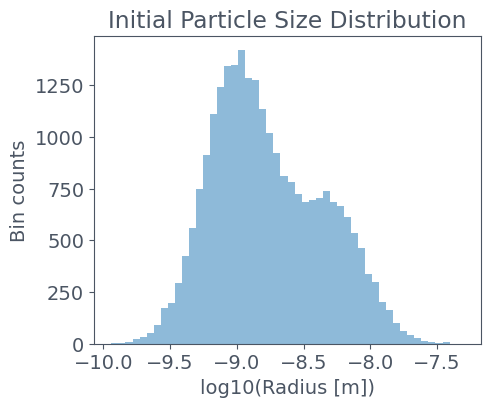

In [5]:
# Generate bi-modal seed particle distribution [m]
radii_seeds = par.particles.get_lognormal_sample_distribution(
    mode=np.array([1e-9, 5e-9]),  # 1 nm and 5 nm modes
    geometric_standard_deviation=np.array([1.8, 1.8]),
    number_of_particles=np.array([1, 0.5]),  # relative mode strength
    number_of_samples=number_of_samples,
)

# Calculate seed mass assuming all are pure fullerene
mass_seeds = (4 / 3) * np.pi * (radii_seeds**3) * density_array[-1]

# Initialize mass speciation matrix: all mass in fullerene (last index)
mass_speciation = np.zeros((number_of_samples, len(list_of_chemicals)))
mass_speciation[:, -1] = mass_seeds

# Activity strategy (ideal molar)
activity_strategy = (
    par.particles.ActivityIdealMolarBuilder()
    .set_molar_mass(molar_mass_array, "kg/mol")
    .build()
)

# Phase indices: all condensed except the seed
phases = np.ones_like(density_array)
phases[-1] = 0  # last species (fullerene) is seed, not condensing

# Surface tension strategy (temperature-dependent)
surface_strategy = (
    par.particles.SurfaceStrategyMassBuilder()
    .set_surface_tension(surface_tension_array, "N/m")
    .set_density(density_array, "kg/m^3")
    .set_phase_index(phases)
    .set_surface_tension_table(surface_tension_table, "N/m")
    .set_temperature_table(temperature_range_table, "K")
    .build()
)

# Build the particle representation
resolved_masses = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy)
    .set_surface_strategy(surface_strategy)
    .set_mass(mass_speciation, "kg")
    .set_density(density_array, "kg/m^3")
    .set_charge(0)  # neutral
    .set_volume(simulation_volume, "m^3")
    .build()
)

# Wrap into full aerosol system with gas phase
aerosol = par.Aerosol(atmosphere=atmosphere, particles=resolved_masses)
print(aerosol)

# 📊 Plot the initial size distribution
fig, ax = plt.subplots()
ax.hist(np.log10(resolved_masses.get_radius()), bins=50, alpha=0.5)
ax.set_xlabel("log10(Radius [m])")
ax.set_ylabel("Bin counts")
ax.set_title("Initial Particle Size Distribution")
plt.show()

## 🔁 Dynamics Setup: Condensation and Coagulation

With the **gas phase**, **atmosphere**, and **initial particle population** defined, we now configure the **physical processes** that drive aerosol evolution:

* **Condensation** — gas-phase species depositing onto particles
* **Coagulation** — particles merging through Brownian motion

These are essential for modeling **soot aging**, **mass transfer**, and **particle growth** in a dynamic combustion environment.

**💧 Condensation Strategy**

We use `CondensationIsothermal` to simulate species uptake based on:

* **Species molar mass**
* **Diffusion coefficient** (assumed constant)
* **Accommodation coefficient** (mass transfer efficiency)
* **Excluded indices**: we **skip partitioning** to the seed species (index `23` = "Fullerene")

> This reflects a system where **Fullerene acts only as a passive core**, with no vapor partitioning.


**⚫ Coagulation Strategy**

Coagulation is handled via `BrownianCoagulationBuilder`, applied to a **particle-resolved distribution** — matching our earlier setup.

Together, these strategies are bundled into `MassCondensation` and `Coagulation` process objects, ready to be passed into the simulation loop.


In [6]:
# 🌀 Condensation strategy setup (isothermal)
condensation_strategy = par.dynamics.CondensationIsothermalStaggered(
    molar_mass=np.array(molar_mass_array),
    diffusion_coefficient=2e-5,  # m²/s
    accommodation_coefficient=1.0,  # perfect uptake
    skip_partitioning_indices=[23],  # skip "Fullerene"
    theta_mode="random",
    num_batches=3,
)

# Wrap into condensation process object
condensation_process = par.dynamics.MassCondensation(condensation_strategy)

# ⚫ Coagulation strategy (Brownian motion)
coagulation_strategy = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("particle_resolved")
    .build()
)

# Wrap into coagulation process object
coagulation_process = par.dynamics.Coagulation(coagulation_strategy)

## 🔥 Modeling the Temperature Profile After Combustion

Below is a **practical, two-stage temperature profile** that is widely used in aerosol post-combustion models. It captures both:

* A **fast entrainment/mixing stage** (sub-second), and
* A **slow ambient dilution stage** (multi-second)

...while remaining smooth, differentiable, and easy to integrate into kinetic solvers.

**🧮 Functional Form**

$$
T(t) = T_\infty +
(T_0 - T_\infty) \cdot \exp\left(-\frac{t}{\tau_1}\right) +
(T_\mathrm{mix} - T_\infty) \cdot \exp\left(-\frac{t}{\tau_2}\right)
$$

Where:

* **T₀** = initial flame or stack temperature
* **T∞** = ambient background temperature (≈ 298 K)
* **Tₘᵢₓ** = temperature after rapid entrainment (\~500–700 K)
* **τ₁** = fast cooling timescale (e.g. 0.05–0.3 s)
* **τ₂** = slow dilution or mixing timescale (e.g. 2–10 s)


**📊 Example Parameter Values**

| Scenario                     | T₀ (K) | Tₘᵢₓ (K) | τ₁ (s) | τ₂ (s) |
| ---------------------------- | ------ | -------- | ------ | ------ |
| Diesel tailpipe (idle)       | 750    | 550      | 0.10   | 4.0    |
| Wick or candle flame         | 1200   | 700      | 0.05   | 6.0    |
| Lab methane burner           | 1450   | 650      | 0.03   | 2.0    |
| Small wood stove in room air | 1050   | 600      | 0.15   | 8.0    |


🧠 **Why use two exponentials?**

* Captures the **supersaturation spike** critical for soot nucleation
* Smooth and differentiable for **ODE solvers**
* Easily fit from real **thermocouple data**
* Matches behavior in **combustion and indoor air** scenarios


In [7]:


def temperature_profile(
    time: Union[float, NDArray[np.float64]],
    initial_temperature: float = 1200.0,
    intermediate_temperature: float = 700.0,
    ambient_temperature: float = 298.0,
    fast_e_folding_time: float = 0.05,
    slow_e_folding_time: float = 4.0,
) -> Union[float, NDArray[np.float64]]:
    """Compute a two-stage exponential cooling profile [K].

    Arguments:
        time: Time after emission [s].
        initial_temperature: Initial temperature at t = 0 [K].
        intermediate_temperature: Intermediate temperature level [K].
        ambient_temperature: Ambient (final) temperature [K].
        fast_e_folding_time: Fast cooling e-folding time constant [s].
        slow_e_folding_time: Slow cooling e-folding time constant [s].

    Returns:
        Temperature as a function of time [K], with two exponential
        decay components toward the ambient temperature.
    """
    t_array = np.asanyarray(time, dtype=float)
    fast_decay = (initial_temperature - ambient_temperature) * np.exp(
        -t_array / fast_e_folding_time
    )
    slow_decay = (intermediate_temperature - ambient_temperature) * np.exp(
        -t_array / slow_e_folding_time
    )
    return ambient_temperature + fast_decay + slow_decay

## 🕒 Time Setup and Temperature Evolution

We now define the **time vector** and compute the **temperature profile** over the course of the simulation.

This temperature is used to update the atmospheric state at each step — controlling **condensation rates** and **vapor pressures** as the parcel cools and mixes with ambient air.


**⏱️ Simulation Time Setup**

* **Total simulation time**: 20 seconds
* **Steps**: 500 (⇒ 0.04 s per step)
* **Substeps**:

  * **Condensation**: 50 per main step
  * **Coagulation**: 1 per main step

> You can optionally use a `logspace` time grid if high temporal resolution is needed near `t = 0`.

**🌡️ Compute the Temperature Profile**

We call the `temperature_profile()` function with typical combustion parameters:

* `T₀ = 1200 K` (flame)
* `Tₘᵢₓ = 700 K` (fast entrainment)
* `T∞ = 300 K` (ambient)
* `τ₁ = 0.05 s`, `τ₂ = 6.0 s` (cooling timescales)

**📈 Plot the Temperature Evolution**

We visualize the cooling curve to verify that it captures the **sharp initial drop** and **gradual ambient approach** expected in realistic post-combustion environments.



Gas mixture at 1200 K, 101325.0 Pa, partitioning=['Benzene' 'Toluene' 'Ethylbenzene' 'p-Xylene' 'Styrene' 'Indene'
 'Naphthalene' 'Acenaphthylene' 'Acenaphthene' 'Anthracene' 'Fluoranthene'
 'Pyrene' 'Chrysene' 'Benzo[a]anthracene' 'Benzo[b]fluoranthene'
 'Benzo[k]fluoranthene' 'Benzo[a]pyrene' 'Perylene' 'Benzo[ghi]perylene'
 'Indeno[1,2,3-cd]pyrene' 'Dibenzo[a,h]anthracene' 'Coronene' 'Ovalene'
 'Fullerene'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMolar
	Surface: SurfaceStrategyMass
	Mass Concentration: 1.279e-08 [kg/m^3]
	Number Concentration: 1.000e+13 [#/m^3]


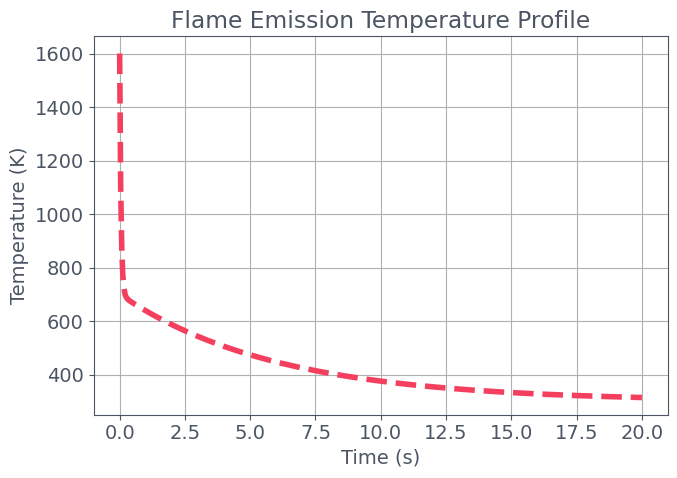

In [8]:
# Show initial aerosol state
print(aerosol)

# Make a copy to apply dynamic updates
aerosol_process = copy.deepcopy(aerosol)

# Simulation timing
total_time = 20  # seconds
total_steps = 500

coagulation_sub_step = 1
condensation_sub_step = 1

time_step = total_time / total_steps
time_array = np.linspace(0, total_time, total_steps)
# Alternative: use logspace for finer early-time resolution
# time_array = np.logspace(-6, np.log10(total_time), total_steps)

time_len = len(time_array)

# Temperature profile over time
temperature_array = temperature_profile(
    time_array,
    initial_temperature=1200.0,
    intermediate_temperature=700.0,
    ambient_temperature=300.0,
    fast_e_folding_time=0.05,
    slow_e_folding_time=6.0,
)

# Set initial temperature in atmosphere
aerosol_process.atmosphere.temperature = temperature_array[0]

# Plot the cooling profile
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    time_array,
    temperature_array,
    color=TAILWIND["rose"]["500"],
    label="Temperature Profile",
    linewidth=4,
    linestyle="--",
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (K)")
ax.set_title("Flame Emission Temperature Profile")
ax.grid()
plt.tight_layout()
plt.show()

## 🧪 Running the Simulation: Condensation + Coagulation

Now we execute the full simulation loop over time, updating the **atmosphere's temperature** at each step and applying the previously defined physical processes:

* **Condensation** (temperature- and species-dependent mass uptake)
* **Coagulation** (Brownian coagulation of particles)

**🔢 What the Loop Tracks**

At each time step, we record:

1. **Radius distribution histogram** (log-binned)
2. **Total particle-phase mass concentration**
3. **Mean (mode) particle diameter**
4. **Species-specific particle-phase mass** (per chemical)

**🧊 Notes on Performance**

* **Condensation** is the most computationally intensive.
* You can disable it (comment it out) to isolate the effect of coagulation.
* Results are stored in arrays for easy plotting after the run.


In [9]:
# Set up histogram bins for radius distribution
bins_lognormal = np.logspace(-10, -6, 200)  # 0.1 nm to 1 μm
distribution_counts = np.zeros((time_len, len(bins_lognormal) - 1))

# Time series storage
mass_concentration = np.zeros_like(time_array)  # kg/m³
mode_diameter = np.zeros_like(time_array)  # m
species_mass = np.zeros((time_len, len(list_of_chemicals)))  # kg

# Simulation loop
for step, _t in enumerate(
    tqdm(time_array, desc="Running Sim", mininterval=0.5)
):
    if step > 0:
        # Update temperature
        aerosol_process.atmosphere.temperature = temperature_array[step]

        # --- Condensation process (optional toggle for speed) ---
        aerosol_process = condensation_process.execute(
            aerosol=aerosol_process,
            time_step=time_step,
            sub_steps=condensation_sub_step,
        )

        # --- Coagulation process ---
        aerosol_process = coagulation_process.execute(
            aerosol=aerosol_process,
            time_step=time_step,
            sub_steps=coagulation_sub_step,
        )

    # Record radius distribution
    distribution_counts[step, :], edges = np.histogram(
        aerosol_process.particles.get_radius(clone=True),
        bins=bins_lognormal,
        density=False,
    )

    # Total particle-phase mass [kg/m³]
    mass_concentration[step] = aerosol_process.particles.get_mass_concentration(
        clone=True
    )

    # Mean particle radius [m]
    radius_temp = aerosol_process.particles.get_radius(clone=True)
    mask_valid = radius_temp > 0
    mode_diameter[step] = np.mean(radius_temp[mask_valid])

    # Species-specific particle mass [kg]
    species_temp = aerosol_process.particles.get_species_mass(clone=True)
    species_mass[step, :] = np.sum(species_temp, axis=0)

# Convert counts and masses to concentrations [#/m³] and [kg/m³]
concentrations = distribution_counts / simulation_volume
species_mass = species_mass / simulation_volume

# Final aerosol state
print(aerosol_process)

Running Sim: 100%|██████████| 500/500 [3:27:57<00:00, 24.95s/it]  

Gas mixture at 314.26959733890095 K, 101325.0 Pa, partitioning=['Benzene' 'Toluene' 'Ethylbenzene' 'p-Xylene' 'Styrene' 'Indene'
 'Naphthalene' 'Acenaphthylene' 'Acenaphthene' 'Anthracene' 'Fluoranthene'
 'Pyrene' 'Chrysene' 'Benzo[a]anthracene' 'Benzo[b]fluoranthene'
 'Benzo[k]fluoranthene' 'Benzo[a]pyrene' 'Perylene' 'Benzo[ghi]perylene'
 'Indeno[1,2,3-cd]pyrene' 'Dibenzo[a,h]anthracene' 'Coronene' 'Ovalene'
 'Fullerene'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMolar
	Surface: SurfaceStrategyMass
	Mass Concentration: 1.279e-08 [kg/m^3]
	Number Concentration: 5.760e+12 [#/m^3]


## 📈 Results: Growth and Cooling Dynamics

We now visualize the output from the simulation loop — focusing on:

1. **Total aerosol mass concentration** (growth from condensation)
2. **Mean particle diameter** (radius evolution from coagulation + condensation)
3. **Cooling temperature trajectory** for reference


**🧪 Interpreting the Results**

* **Mass increases** as condensable vapors partition into the particle phase.
* **Mean diameter grows** from both **condensation** and **coagulation**.
* Some **numerical wiggles** may appear due to the **Euler stepping scheme** — which is simple but not adaptive or error-controlled.

> 🔍 You can reduce wiggle artifacts by:
>
> * Increasing `total_steps`
> * Switching to adaptive integrators in future Particula versions (or add your own!)


**📊 Plot 1: Total Mass Concentration**

This plot shows how much gas-phase material is transferred to particles over time.

**📏 Plot 2: Mean Particle Diameter**

This shows how particle size evolves, usually increasing due to condensation and merging.


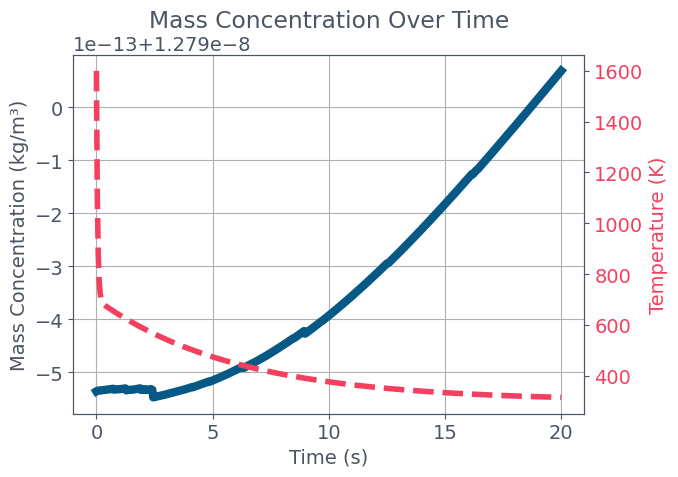

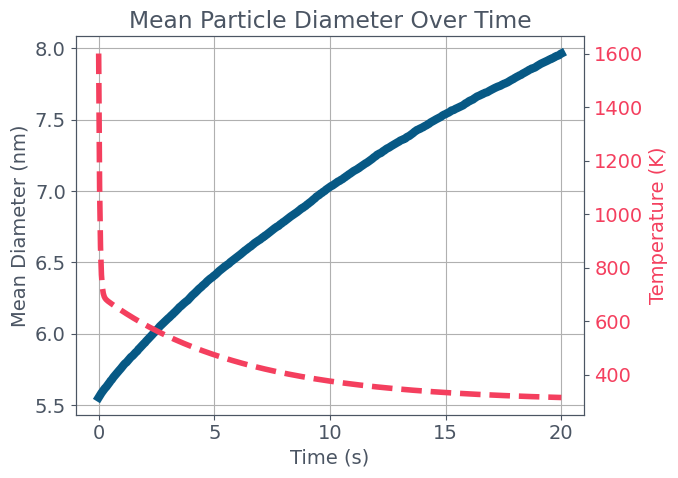

In [10]:
dp_in_nm = 2 * 1e9  # Convert radius [m] → diameter [nm]

# Plot 1: Mass concentration over time
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    time_array,
    mass_concentration,
    color=TAILWIND["sky"]["800"],
    linewidth=6,
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mass Concentration (kg/m³)")
ax.set_title("Mass Concentration Over Time")
ax.grid()

# Add temperature on second axis
twinx = ax.twinx()
twinx.plot(
    time_array,
    temperature_array,
    color=TAILWIND["rose"]["500"],
    linestyle="--",
    linewidth=4,
)
twinx.set_ylabel("Temperature (K)", color=TAILWIND["rose"]["500"])
twinx.tick_params(axis="y", labelcolor=TAILWIND["rose"]["500"])

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Mean diameter over time
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    time_array,
    mode_diameter * dp_in_nm,  # mean diameter [nm]
    color=TAILWIND["sky"]["800"],
    linewidth=6,
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mean Diameter (nm)")
ax.set_title("Mean Particle Diameter Over Time")
ax.grid()

# Add temperature on second axis
twinx = ax.twinx()
twinx.plot(
    time_array,
    temperature_array,
    color=TAILWIND["rose"]["500"],
    linestyle="--",
    linewidth=4,
    label="Temperature (K)",
)
twinx.set_ylabel("Temperature (K)", color=TAILWIND["rose"]["500"])
twinx.tick_params(axis="y", labelcolor=TAILWIND["rose"]["500"])

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🧪 Where the Mass Is: Species-Level Partitioning

In this section, we explore **how different chemical species contribute** to the particle-phase mass throughout the simulation.

We plot:

1. **Absolute species mass concentrations** — more stable and interpretable
2. **Mass fractions** — show relative speciation but may exaggerate numerical wiggles

> ⚠️ Mass fractions are **sensitive to numerical artifacts**, especially when the denominator (total mass) is small or fluctuating.


**📊 Plot 1: Species Mass Concentration (kg/m³)**

This stack plot shows how much of each species has condensed into the particle phase.

* The y-axis is the total particle-phase concentration of each compound.
* The plot grows as vapor species condense onto seeds.


**📊 Plot 2: Particle Mass Fraction**

This plot shows the **relative speciation** of the condensed-phase.

* Each band represents the **mean mass fraction** of a species in particles.
* The temperature overlay helps relate supersaturation to species uptake.


> ✅ These plots let you **diagnose volatility**, **partitioning trends**, and **multicomponent interactions**.


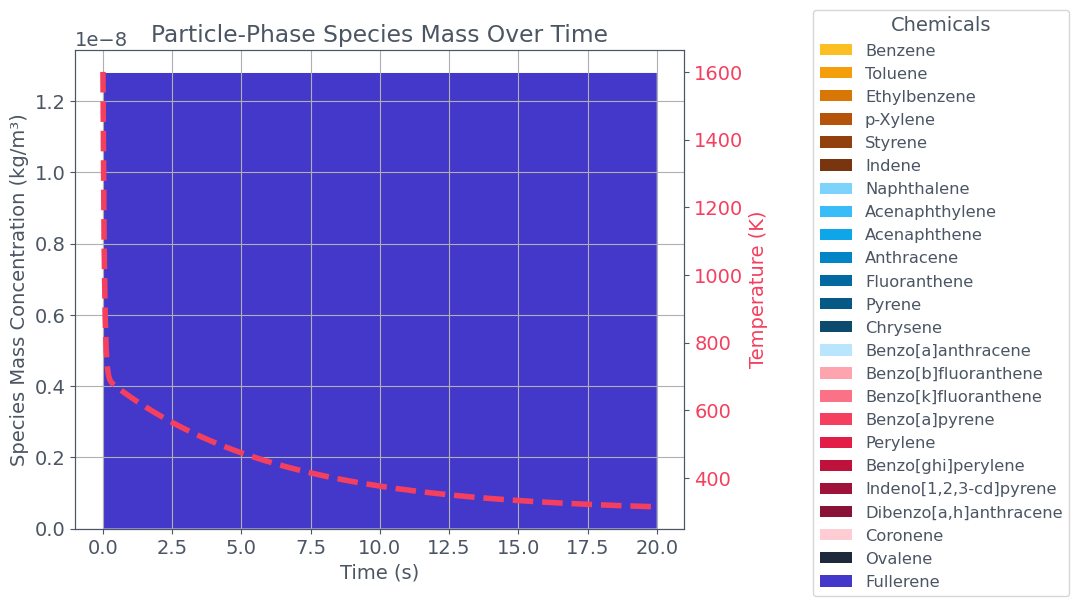

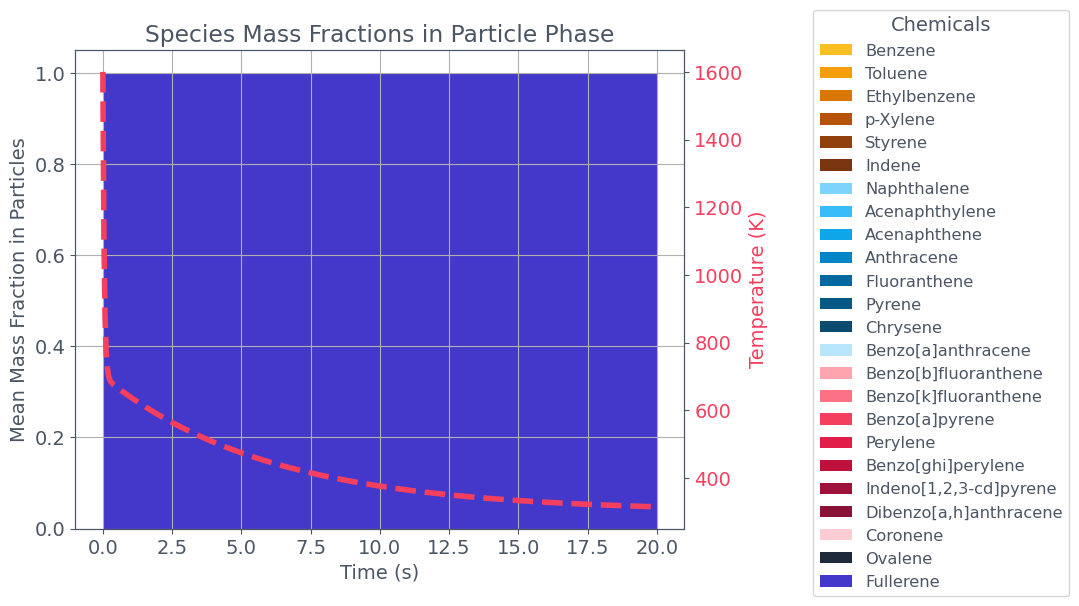

In [11]:
# 📊 Plot 1: Absolute species mass concentration [kg/m³]
fig, ax = plt.subplots(figsize=(8, 6))

# stackplot expects shape (n_series, n_times), so transpose
ax.stackplot(
    time_array,
    species_mass.T,  # shape (n_species, n_time)
    labels=list_of_chemicals,
    colors=color_list,
    alpha=1.0,
)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Species Mass Concentration (kg/m³)")
ax.set_title("Particle-Phase Species Mass Over Time")
ax.grid(True)

# Overlay temperature curve
twinx = ax.twinx()
twinx.plot(
    time_array,
    temperature_array,
    color=TAILWIND["rose"]["500"],
    linestyle="--",
    label="Temperature (K)",
    linewidth=4,
)
twinx.set_ylabel("Temperature (K)", color=TAILWIND["rose"]["500"])
twinx.tick_params(axis="y", labelcolor=TAILWIND["rose"]["500"])

# External legend
fig.legend(
    list_of_chemicals,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    title="Chemicals",
    fontsize="small",
)
plt.tight_layout(rect=(0, 0, 1, 1))
plt.show()

# 📊 Plot 2: Mass fraction (normalized by total particle mass)
mass_fraction = species_mass / np.sum(species_mass, axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(
    time_array,
    mass_fraction.T,
    labels=list_of_chemicals,
    colors=color_list,
    alpha=1.0,
)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Mean Mass Fraction in Particles")
ax.set_title("Species Mass Fractions in Particle Phase")
ax.grid(True)

# Overlay temperature
twinx = ax.twinx()
twinx.plot(
    time_array,
    temperature_array,
    color=TAILWIND["rose"]["500"],
    linestyle="--",
    label="Temperature (K)",
    linewidth=4,
)
twinx.set_ylabel("Temperature (K)", color=TAILWIND["rose"]["500"])
twinx.tick_params(axis="y", labelcolor=TAILWIND["rose"]["500"])

fig.legend(
    list_of_chemicals,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    title="Chemicals",
    fontsize="small",
)
plt.tight_layout(rect=(0, 0, 1, 1))
plt.show()


## 📉 Final Plot: Particle Size Distribution Over Time

The last plot shows the **evolution of particle number concentration** across the **radius spectrum** throughout the simulation.

* It reveals **growth dynamics** from \~1 nm up to submicron scale
* Shows how condensation **fills out the distribution**
* Captures coagulation **shifting mass toward larger sizes**

**🔬 What It Shows**

* X-axis: Time after emission \[s]
* Y-axis: Particle radius \[m] (log scale)
* Color: Number concentration \[#/m³] in each size bin

> ⚠️ Interpolation artifacts can occur if `sub_steps` is too low or if the system is stiff — increase resolution or use adaptive solvers for higher precision.

✅ This completes your simulation visualization pipeline: from gas-phase precursor evolution to fully resolved, dynamic aerosol size and composition.


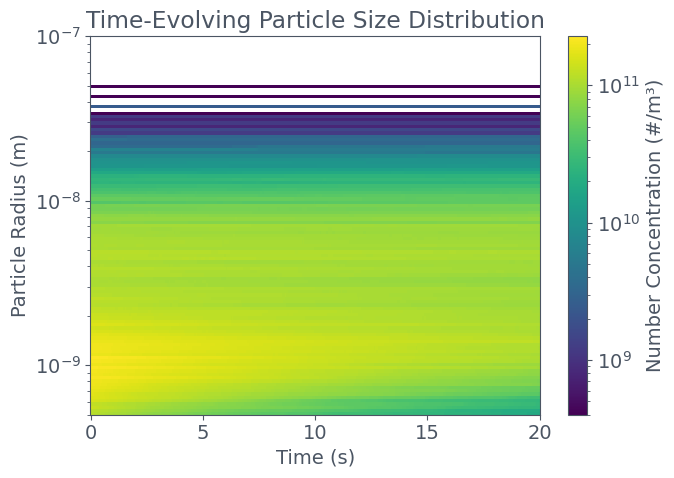

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

# Create mesh grid: time vs radius bins (left edges only)
X, Y = np.meshgrid(time_array, edges[:-1])

# Plot number concentration on a log scale
mesh = ax.pcolormesh(
    X,
    Y,
    concentrations.T,  # shape (n_bins, n_times)
    shading="auto",
    norm=LogNorm(
        vmin=concentrations[concentrations > 0].min(),
        vmax=concentrations.max(),
    ),
)

ax.set_yscale("log")
ax.set_ylim(5e-10, 1e-7)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Particle Radius (m)")
ax.set_title("Time-Evolving Particle Size Distribution")

# Colorbar for number concentration
fig.colorbar(mesh, label="Number Concentration (#/m³)")

plt.tight_layout()
plt.show()

## ✅ Summary: Modeling Soot Formation and Growth Using Particula

In this notebook, we used **Particula** to simulate the **formation and transformation of soot precursors** in a post-combustion environment. We built a fully coupled system combining:

* A **multicomponent gas-phase mixture** of aromatic and polycyclic hydrocarbons
* A **lognormal seed particle distribution**, representing incipient soot cores
* A **two-stage cooling temperature profile**, capturing entrainment and dilution dynamics
* **Condensation and coagulation processes**, applied step-by-step to resolve mass transfer and particle growth

The simulation tracked the evolution of particle **mass concentration**, **mean diameter**, **size distribution**, and **species-level mass partitioning** over time.

By using a realistic cooling profile, we reproduced the **supersaturation window** where low-volatility species (e.g. PAHs) rapidly condense — a critical moment in soot inception. The growth of particles in both number and mass was clearly visible, along with shifts in chemical speciation as the temperature dropped.

---

## 🧠 Take-Home Points

1. **Post-flame condensation drives rapid aerosol mass growth**
   The temperature drop from 1200 K to ambient creates sharp vapor pressure gradients, allowing semi-volatile PAHs to condense onto seed particles almost immediately.

2. **Soot-forming chemistry is driven by low-volatility species**
   Larger PAHs (e.g., benzo\[a]pyrene, coronene) dominate particle-phase mass over time, particularly once smaller aromatics remain in the vapor phase.

3. **Euler time-stepping is simple but introduces wiggles**
   Our choice of fixed-step Euler integration creates slight numerical noise in mass fraction plots — highlighting the tradeoff between speed and precision. Higher number of steps or adaptive stepping may improve accuracy.

4. **Particula’s modular design supports combustion plume modeling**
   With `Gas`, `Particle`, and `Atmosphere` objects plus tunable process builders, you can recreate real-world conditions for combustion emissions, indoor air pollution, and exposure assessments.

---

This notebook serves as a **foundational framework** for modeling **soot dynamics in cooling combustion plumes**. From here, you can extend it to explore:

* Different **burn conditions** (diesel, wood smoke, indoor flames)
* Effects of **ventilation, dilution rate**, or **ambient pressure**
* **Nucleation kinetics**, **oxidation**, or **secondary organic aerosol (SOA)** formation
* Integration with **exposure models** for health and climate impact studies


